In [1]:
from comet_ml import Experiment
import comet_ml
from comet_ml.integration.pytorch import log_model
from libs import dataloader
import torch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import mdmm

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# W bosons regressions with a Transformer

## Dataset Loading

In [2]:
datafolder = "/eos/user/d/dvalsecc/EFT_PhD_Course/training_datasets"

# Usage example
input_paths_training = [ f"{datafolder}/{f}_training.npy" for f in ["jet_data", "jet_padding_mask", "lepton_data", "met_data", "nu_data", "W_data"]]
input_paths_validation = [ f"{datafolder}/{f}_validation.npy" for f in ["jet_data", "jet_padding_mask","lepton_data", "met_data", "nu_data", "W_data"]]

dataset_train = dataloader.ChunkedNumpyDataset(input_paths_training, max_events=1000000, device="cuda")
dataset_val  = dataloader.ChunkedNumpyDataset(input_paths_validation, max_events=500000, device="cuda")

# Create DataLoader
batch_size = 512
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=True)


## Model definition

Let's start defining a basic transformer with encoder and decoder layers.

In [2]:
import torch
import torch.nn as nn
from torch.nn import Transformer, TransformerEncoderLayer, TransformerDecoderLayer

class MaskedTransformer(nn.Module):
    def __init__(self, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward=512):
        super().__init__()
        #https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html#torch.nn.Transformer
        self.transformer = Transformer(d_model=d_model,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       batch_first = True # Inputs will be [batch, sequence, dim]
                                      )

    def forward(self, src, tgt, src_key_padding_mask=None, tgt_key_padding_mask=None):
        output = self.transformer(src, tgt, 
                                  src_key_padding_mask=src_key_padding_mask,
                                  tgt_key_padding_mask=tgt_key_padding_mask)
        return output


Let's pass to the transformer encode the jets and get out from the Transformer decoder 2 objetcs. 

NB: the number of elements in the decoder is not fixed in the definition of the model.

In [4]:
# Example usage
d_model = 5
nhead = 1
num_encoder_layers = 4
num_decoder_layers = 4

model = MaskedTransformer(d_model, nhead, num_encoder_layers, num_decoder_layers)
model.to("cuda")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


MaskedTransformer(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-3): 4 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=5, out_features=5, bias=True)
          )
          (linear1): Linear(in_features=5, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=5, bias=True)
          (norm1): LayerNorm((5,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((5,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((5,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-3): 4 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
          

In [5]:
inputs = next(iter(dataloader_train))
jets, jets_mask, lepton, met, nu, W = inputs
tgt = torch.zeros((batch_size, 2, 5), dtype=torch.float32).to("cuda")

W_out = model(jets, tgt, src_key_padding_mask=jets_mask==0)
W_out.shape

torch.Size([512, 2, 5])

In [6]:
W_out

tensor([[[ 0.5241, -1.5742,  0.4423,  1.2700, -0.6622],
         [ 0.7295, -1.2645, -0.3537,  1.5281, -0.6394]],

        [[-0.9071,  1.9016, -0.3520,  0.0186, -0.6610],
         [-0.5428, -0.5910,  1.4954, -1.1944,  0.8327]],

        [[-0.0083, -0.4848,  1.0530, -1.6027,  1.0428],
         [ 0.1545, -0.1754, -0.7403, -1.0524,  1.8137]],

        ...,

        [[-1.1001,  0.0799,  1.3639, -1.1373,  0.7935],
         [-1.0225, -0.6469,  1.6522, -0.6262,  0.6434]],

        [[-0.3275,  0.5939,  1.6014, -1.2740, -0.5938],
         [ 0.4596, -1.0489,  1.4116, -1.2351,  0.4128]],

        [[ 0.5495, -1.6527,  0.5441, -0.5905,  1.1497],
         [ 0.3502, -1.4621,  0.6911, -0.8321,  1.2528]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)

Until now our model makes little sense. We are passing the jets to the Transformer encoder, and then passing empty tensors [Batch, 2, 5] to the Transformer decoder. 

The Transformer decoder manipulate the 2 empty tensors (columns) and using information from the encoder, returns them. 

**Problems**: 
- At the moment the transformer dimension is fixed to the dimension of the last axis of the input --> very limited
- The same for the target.

We need more capacity

### Transformer with projections in an embedded space

In [7]:
import torch
import torch.nn as nn
from torch.nn import Transformer, TransformerEncoderLayer, TransformerDecoderLayer

class WWRegressor(nn.Module):
    
    def __init__(self, d_model=128, nhead=8, 
                 num_encoder_layers=2, 
                 num_decoder_layers=2, 
                 dim_feedforward=512,
                 output_dim=4,
                 regression_net=[64,64],
                 jet_features = 5
                ):
        super().__init__()
        self.d_model = d_model
        self.transformer = MaskedTransformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward)

        self.embedding_jets = nn.Sequential(
            nn.Linear(jet_features, d_model),
            nn.ReLU()
        )

        _layers = [nn.Linear(d_model, regression_net[0]), nn.ReLU()]
        for i in range(len(regression_net)-1):
            _layers.append(nn.Linear(regression_net[i], regression_net[i+1]))
            _layers.append(nn.ReLU())
            
        _layers.append(nn.Linear(regression_net[-1], 4))
        self.regression_net = nn.Sequential(*_layers)

    def forward(self, jets, jets_mask):
        emb = self.embedding_jets(jets)
        tgt = torch.zeros((jets.shape[0], 2, self.d_model), dtype=torch.float32).to("cuda")
        out_transf = self.transformer(src=emb, tgt=tgt, src_key_padding_mask=jets_mask)

        out = self.regression_net(out_transf)
        return out
        

In [8]:
# Example usage
d_model = 64
nhead = 8
num_encoder_layers = 4
num_decoder_layers = 4

model = WWRegressor(d_model, nhead, num_encoder_layers, num_decoder_layers,
                   regression_net=[32,32])
model.to("cuda")

WWRegressor(
  (transformer): MaskedTransformer(
    (transformer): Transformer(
      (encoder): TransformerEncoder(
        (layers): ModuleList(
          (0-3): 4 x TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
            )
            (linear1): Linear(in_features=64, out_features=512, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=512, out_features=64, bias=True)
            (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
          )
        )
        (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (decoder): TransformerDecoder(
        (layers): ModuleList(
          (0-3): 4 x

In [11]:
inputs = next(iter(dataloader_train))
jets, jets_mask, lepton, met, nu, W = inputs
W_out = model(jets, jets_mask==0)
W_out.shape

torch.Size([512, 2, 4])

In [12]:
W_out

tensor([[[ 0.1286, -0.3454,  0.1123, -0.0353],
         [ 0.0130, -0.3706,  0.0544, -0.1228]],

        [[ 0.1705, -0.1802,  0.1010,  0.0210],
         [ 0.1415, -0.2674,  0.1315, -0.0402]],

        [[ 0.1556, -0.2411,  0.0442, -0.0376],
         [ 0.0508, -0.2535, -0.0252, -0.1139]],

        ...,

        [[ 0.1233, -0.2834,  0.0140, -0.0669],
         [ 0.1182, -0.3467, -0.0357, -0.1191]],

        [[ 0.0763, -0.3486,  0.0679, -0.0531],
         [ 0.0540, -0.4217,  0.0188, -0.1290]],

        [[ 0.1064, -0.2920,  0.0020, -0.0028],
         [ 0.1909, -0.2603,  0.1056,  0.0516]]], device='cuda:0',
       grad_fn=<ViewBackward0>)

The numbers are still nonsense of course, we haven't trained the model. But now the shapes are handled correctly. 
We need now to add also the leptons and met to the inputs. 

### Adding leptons and MET to the inputs
Leptons and MET need a different embedding network to make the dimensions of the input tensors to the transformer the same

In [13]:
datafolder = "/eos/user/d/dvalsecc/EFT_PhD_Course/training_datasets"

# Usage example
input_paths_training = [ f"{datafolder}/{f}_training.npy" for f in ["jet_data", "lepton_data", "met_data","jetlepmet_padding_mask",  "nu_data", "W_data"]]
input_paths_validation = [ f"{datafolder}/{f}_validation.npy" for f in ["jet_data", "lepton_data", "met_data","jetlepmet_padding_mask", "nu_data", "W_data"]]

dataset_train = dataloader.ChunkedNumpyDataset(input_paths_training, max_events=500000, device="cuda")
dataset_val  = dataloader.ChunkedNumpyDataset(input_paths_validation, max_events=200000, device="cuda")

# Create DataLoader
batch_size = 1024
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size*5, shuffle=False)

In [3]:
import torch
import torch.nn as nn
from torch.nn import Transformer, TransformerEncoderLayer, TransformerDecoderLayer

def get_obj_type_tensor(max_njets):
    o = torch.zeros((max_njets+2+1, 1), dtype=torch.float32)
    o[-3:-1,0] = 1.
    o[-1,0] = -1.
    return o

class WWRegressorComplete(nn.Module):
    
    def __init__(self, d_model=128, nhead=8, 
                 num_encoder_layers=2, 
                 num_decoder_layers=2, 
                 dim_feedforward=512,
                 output_dim=4,
                 regression_net=[64,64],
                 jet_features = 5,
                 let_features = 3, 
                 met_features = 2,
                 max_njets= 13,
                ):
        super().__init__()
        self.d_model = d_model
        self.transformer = MaskedTransformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward)

        self.embedding_jets = nn.Sequential(
            nn.Linear(jet_features, d_model-1), # -1 to account for the additional label added to the features
            nn.SELU()
        )
        self.embedding_lep = nn.Sequential(
            nn.Linear(let_features, d_model-1),
            nn.SELU()
        )
        self.embedding_met = nn.Sequential(
            nn.Linear(met_features, d_model-1),
            nn.SELU()
        )
        
        _layers = [nn.Linear(d_model, regression_net[0]), nn.SELU()]
        for i in range(len(regression_net)-1):
            _layers.append(nn.Linear(regression_net[i], regression_net[i+1]))
            _layers.append(nn.SELU())
            
        _layers.append(nn.Linear(regression_net[-1], output_dim))
        self.regression_net = nn.Sequential(*_layers)

        self.register_buffer('obj_type', get_obj_type_tensor(max_njets))
        self.register_buffer("decoder_null_tokens", torch.zeros((2, self.d_model), dtype=torch.float32))
        

    def forward(self, jets, leptons, met, full_mask):
        batch_size = jets.size(0)
        emb_jets = self.embedding_jets(jets)
        emb_lep = self.embedding_lep(leptons)
        emb_met = self.embedding_met(met)

        labels = self.obj_type.expand(batch_size, *list(self.obj_type.shape))
        
        emb = torch.cat([emb_jets, emb_lep, emb_met], dim=1)
        emb = torch.cat([emb, labels], dim=-1)

        # expanding the mask for lepton and met
        
        tgt = self.decoder_null_tokens.expand(batch_size, *list(self.decoder_null_tokens.shape))
        out_transf = self.transformer(src=emb, tgt=tgt, src_key_padding_mask=full_mask)

        out = self.regression_net(out_transf)
        return out
        

In [16]:
# Example usage
d_model = 64
nhead = 4
num_encoder_layers = 2
num_decoder_layers = 2

model = WWRegressorComplete(d_model, nhead, num_encoder_layers, num_decoder_layers,
                   regression_net=[32,32])
model.to("cuda")

WWRegressorComplete(
  (transformer): MaskedTransformer(
    (transformer): Transformer(
      (encoder): TransformerEncoder(
        (layers): ModuleList(
          (0-1): 2 x TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
            )
            (linear1): Linear(in_features=64, out_features=512, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=512, out_features=64, bias=True)
            (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
          )
        )
        (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (decoder): TransformerDecoder(
        (layers): ModuleList(
          (0

In [17]:
inputs = next(iter(dataloader_train))
jets, lepton, met, full_mask, nu, W = inputs
W_out = model(jets, lepton, met, full_mask==0)
W_out.shape

torch.Size([1024, 2, 4])

## Training Loop

In [4]:
datafolder = "/eos/user/d/dvalsecc/EFT_PhD_Course/training_datasets"

# Usage example
input_paths_training = [ f"{datafolder}/{f}_training.npy" for f in ["jet_data", "lepton_data", "met_data","jetlepmet_padding_mask",  "nu_data", "W_data"]]
input_paths_validation = [ f"{datafolder}/{f}_validation.npy" for f in ["jet_data", "lepton_data", "met_data","jetlepmet_padding_mask", "nu_data", "W_data"]]

dataset_train = dataloader.ChunkedNumpyDataset(input_paths_training, max_events=400000, device="cuda")
dataset_val  = dataloader.ChunkedNumpyDataset(input_paths_validation, max_events=200000, device="cuda")

# Create DataLoader
batch_size = 1024
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size*5, shuffle=False)

Let's have a function plotting some validation plots for the regressed Ws

In [20]:
def validation_plots(W, W_out):
    f1 , axs = plt.subplots(2, 4, figsize=(16, 10))
    for i in range(2):
        for j in range(4):
            f = plt
            axs[i][j].hist2d(W[:,i, j].cpu().numpy(), W_out[:,i, j].cpu().numpy(),
              bins=60, range=((-3,3),(-3,3)),
            norm=LogNorm())
            if j == 0:
                axs[i][j].set_xlabel("Target pt")
                axs[i][j].set_ylabel("Regressed pt")
            elif j == 1:
                axs[i][j].set_xlabel("Target eta")
                axs[i][j].set_ylabel("Regressed eta")
            elif j == 2:
                axs[i][j].set_xlabel("Target phi")
                axs[i][j].set_ylabel("Regressed phi")
            elif j == 3:
                axs[i][j].set_xlabel("Target mass")
                axs[i][j].set_ylabel("Regressed mass")

    f2 , axs = plt.subplots(2, 4, figsize=(16, 10))
    for i in range(2):
        for j in range(4):
            f = plt
            axs[i][j].hist(W[:,i, j].cpu().numpy(), bins=80, range=(-3,3), label="Target", histtype="step")
            axs[i][j].hist(W_out[:,i, j].cpu().numpy(), bins=80, range=(-3,3), label="Regressed", histtype="step")
            axs[i][j].legend()
            if j == 0:
                axs[i][j].set_xlabel("pt")
            elif j == 1:
                axs[i][j].set_xlabel("eta")
            elif j == 2:
                axs[i][j].set_xlabel("phi")
            elif j == 3:
                axs[i][j].set_xlabel("mass")

    f3 , axs = plt.subplots(1, 4, figsize=(16, 5))
    for j in range(4):
        axs[j].hist2d(W_out[:,0, j].cpu().numpy()-W[:,0,j].cpu().numpy(),
                      W_out[:,1, j].cpu().numpy()-W[:,1,j].cpu().numpy(),
                    bins=80, range=((-2,2),(-2,2)), 
                    norm=LogNorm())
        if j == 0:
            axs[j].set_xlabel("Delta pt W1")
            axs[j].set_ylabel("Delta pt W2")
        elif j == 1:
            axs[j].set_xlabel("Delta eta W1")
            axs[j].set_ylabel("Delta eta W2")
        elif j == 2:
            axs[j].set_xlabel("Delta phi W1")
            axs[j].set_ylabel("Delta phi W1")
        elif j == 3:
            axs[j].set_xlabel("Delta mass W1")
            axs[j].set_ylabel("Delta mass W2")

    return f1,f2, f3

In [6]:
def train(model, device, loader, val_loader,  optimizer, criterion, epochs, plot=False):
    model.train()
    for epoch in range(epochs):
        model.train()
        for batch_idx, (jets, lepton, met, full_mask, nu, W) in enumerate(loader):
            
            optimizer.zero_grad()
            W_out = model(jets, lepton, met, full_mask==0)
            
            loss = criterion(W_out, W).mean()
            if batch_idx % 100 == 0:
                print(f"epoch {epoch}, step {batch_idx}, Loss: {loss}")
                
            loss.backward()
            optimizer.step()
        # # Log metrics
        # if experiment:
        #     experiment.log_metric("train_loss_epoch", loss.item(), step=epoch)
        
        # Validation loss
        #model.eval()
        val_loss = 0.  
        with torch.no_grad():
            for jets_val, lepton_val, met_val ,full_mask_val, nu_val, W_val in val_loader:
                W_out_val = model(jets_val, lepton_val, met_val,full_mask_val==0)
                loss = criterion(W_out_val, W_val)
                val_loss += loss.nanmean().item()
            
            if plot:
                _ = validation_plots(W_val, W_out_val)
                plt.show()
            
            val_loss = val_loss / len(val_loader)
            
            print(f"epoch {epoch}, validation loss: {val_loss}")
        
        print("End of epoch")
    return model

In [9]:
num_epochs = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

d_model = 32
nhead = 4
num_encoder_layers = 2
num_decoder_layers = 2
learning_rate = 1e-4

model = WWRegressorComplete(d_model, nhead, num_encoder_layers, num_decoder_layers,
                   regression_net=[16])
model.to(device)

print(f"Model with {count_parameters(model)} parameters")

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss(reduction='none')

# Create Comet.ml experiment
# exp = Experiment(
#              api_key=comet_token,
#              project_name="PhDCourse",
#              workspace="valsdav",
#              auto_output_logging = "simple",
#              # disabled=True
#          )
# exp.log_parameters({"model_param_tot": count_parameters(model)})
#exp.display(tab='panels')

trained_model = train(model, device, dataloader_train, dataloader_val, optimizer, criterion, num_epochs)

Model with 160359 parameters
epoch 0, step 0, Loss: 1.1336512565612793
epoch 0, step 100, Loss: 0.8057268261909485
epoch 0, step 200, Loss: 0.7614318132400513
epoch 0, step 300, Loss: 0.8134192228317261
epoch 0, validation loss: 0.7607271000742912
End of epoch
epoch 1, step 0, Loss: 0.7517014145851135
epoch 1, step 100, Loss: 0.7705392837524414
epoch 1, step 200, Loss: 0.7385294437408447
epoch 1, step 300, Loss: 0.8001151084899902
epoch 1, validation loss: 0.7504647433757782
End of epoch
epoch 2, step 0, Loss: 0.7383198738098145
epoch 2, step 100, Loss: 0.7600220441818237
epoch 2, step 200, Loss: 0.7333881855010986
epoch 2, step 300, Loss: 0.7913548350334167
epoch 2, validation loss: 0.745500561594963
End of epoch
epoch 3, step 0, Loss: 0.7351382970809937
epoch 3, step 100, Loss: 0.756630539894104
epoch 3, step 200, Loss: 0.729314923286438
epoch 3, step 300, Loss: 0.7884448766708374
epoch 3, validation loss: 0.7426824539899826
End of epoch
epoch 4, step 0, Loss: 0.732502818107605
epoch

(<Figure size 1600x1000 with 8 Axes>,
 <Figure size 1600x1000 with 8 Axes>,
 <Figure size 1600x500 with 4 Axes>)

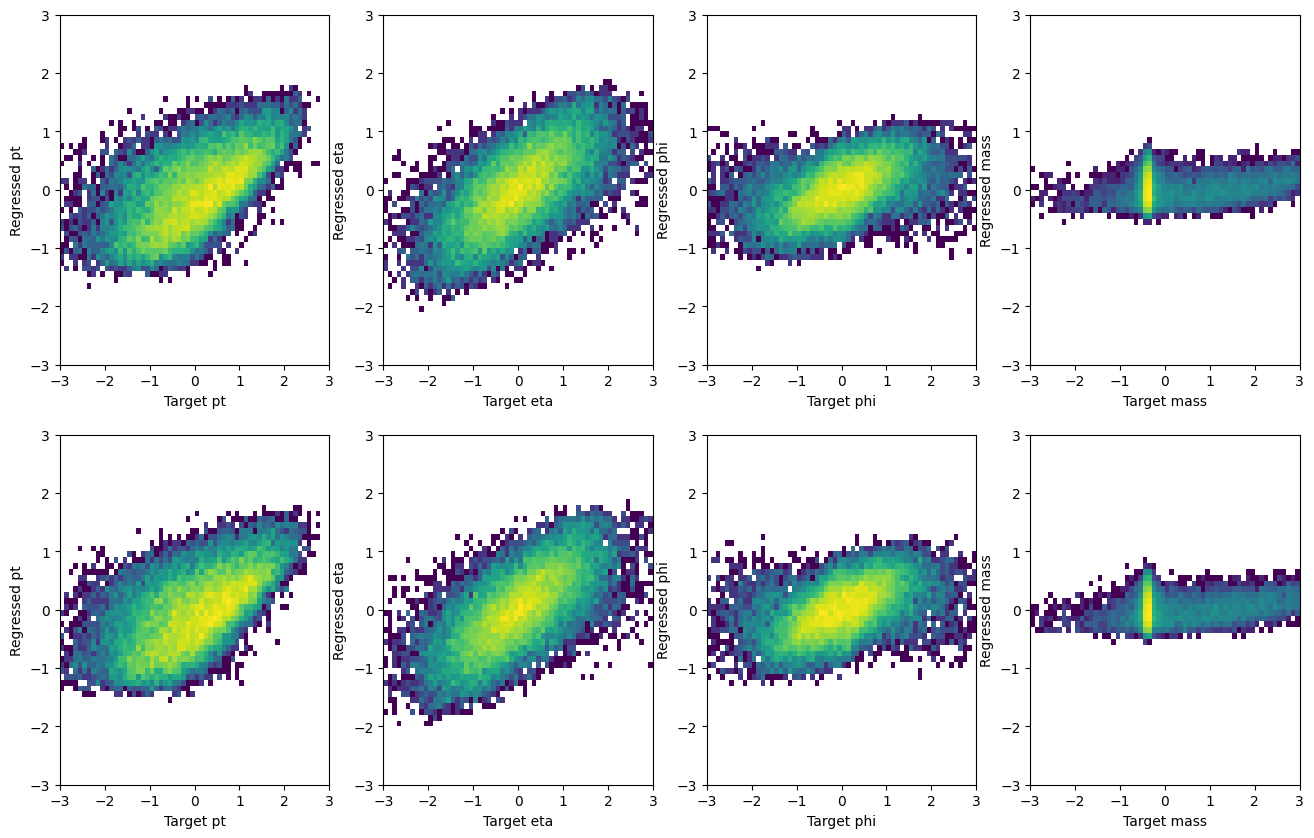

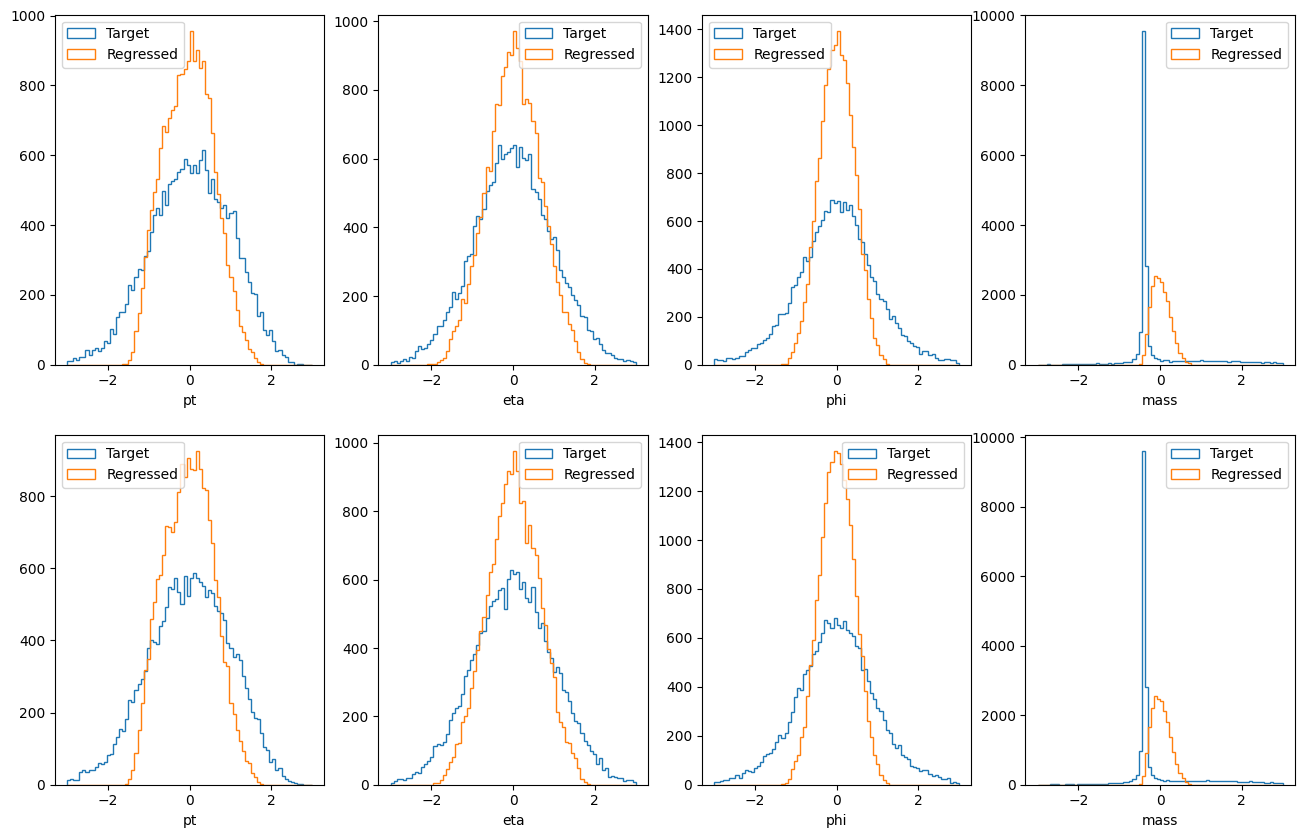

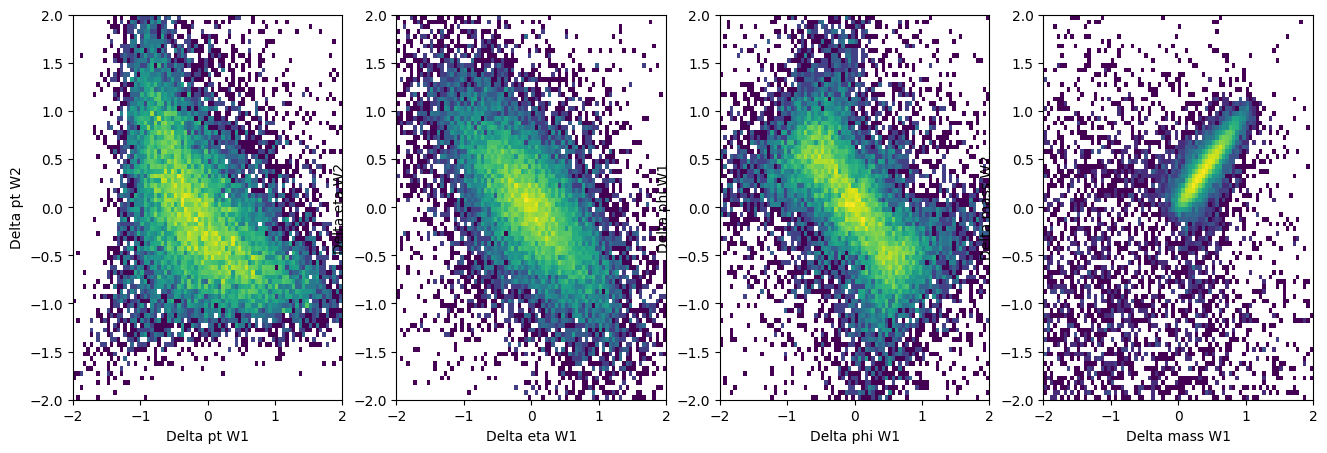

In [10]:
#Larger evaluation
with torch.no_grad():
    jets, lepton, met,full_mask, nu, W = dataset_val[0:20000]
    W_out = model(jets, lepton, met,full_mask==0)
    loss = criterion(W_out, W)

validation_plots(W, W_out)

In [11]:
torch.save(model.state_dict(), "models/model_WWregr_initial.pt")

## Training with MMD loss

Often regressions are biased toward the most probable value. This is a "feature" of the MSE loss.
If the value to regress is not "flat" but has long tails, the regression will often collpapse on the most probable case.

Using an alternative regression loss such as the **Huber loss** [wikipedia](https://en.wikipedia.org/wiki/Huber_loss) can alleviate the problem, but not solve it completely. 

To counteract this problem we can add to the loss a term that is measuring the difference between the distribution of the target variable and the distribution of the output of the regression./



In [12]:
from libs.mmd import MMD

In [13]:
torch.cuda.empty_cache()

In [14]:
datafolder = "/eos/user/d/dvalsecc/EFT_PhD_Course/training_datasets"

# Usage example
input_paths_training = [ f"{datafolder}/{f}_training.npy" for f in ["jet_data", "lepton_data", "met_data","jetlepmet_padding_mask",  "nu_data", "W_data"]]
input_paths_validation = [ f"{datafolder}/{f}_validation.npy" for f in ["jet_data", "lepton_data", "met_data","jetlepmet_padding_mask", "nu_data", "W_data"]]

dataset_train = dataloader.ChunkedNumpyDataset(input_paths_training, max_events=400000, device="cuda")
dataset_val  = dataloader.ChunkedNumpyDataset(input_paths_validation, max_events=200000, device="cuda")

# Create DataLoader
batch_size = 1024
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size*6, shuffle=False)

In [15]:
def train_withMMD(model, device, loader, val_loader,  optimizer, criterion, epochs, plot=False):
    for epoch in range(epochs):
        model.train()
        for batch_idx, (jets, lepton, met, full_mask, nu, W) in enumerate(loader):
            
            optimizer.zero_grad()
            W_out = model(jets, lepton, met, full_mask==0)
            mask_nan = torch.isnan(W_out).any(axis=(1,2))
            MMDs_1 = []
            MMDs_2 = []
            for i in range(4):
                MMDs_1.append(MMD(W[~mask_nan][:,0,i:i+1], W_out[~mask_nan][:,0,i:i+1], kernel="multiscale", device=device, dtype=torch.float32))
                MMDs_2.append(MMD(W[~mask_nan][:,1,i:i+1], W_out[~mask_nan][:,1,i:i+1], kernel="multiscale", device=device, dtype=torch.float32))
            MMD_loss_1 = sum(MMDs_1)/4
            MMD_loss_2 = sum(MMDs_2)/4
            
            loss_huber = criterion(W_out, W).nanmean()
            loss =  loss_huber +  MMD_loss_1 + MMD_loss_2
            
            
            if batch_idx % 100 == 0:
                print(f"epoch {epoch}, step {batch_idx}, Loss: {loss.item():.4f}, loss regr: {loss_huber.item():.4f},  MMD W1: {MMD_loss_1.item():.4f}, MMD W2: {MMD_loss_2.item():.4f} ")
                  
            loss.backward()
            optimizer.step()
        
        # Validation loss
        #model.eval()  #I'm having problems with model.eval
        val_loss = 0.  
        val_loss_huber = 0.
        val_loss_mmd_w1 = 0.
        val_loss_mmd_w2 = 0.
        
        with torch.no_grad():
            for jets_val, lepton_val, met_val ,full_mask_val, nu_val, W_val in val_loader:
                W_out_val = model(jets_val, lepton_val, met_val, full_mask_val==0)
       
                mask_nan_val = torch.isnan(W_out_val).any(axis=(1,2))
                MMDs_1_val = []
                MMDs_2_val = []
                for i in range(4):
                    MMDs_1_val.append(MMD(W_val[~mask_nan_val][:,0,i:i+1], W_out_val[~mask_nan_val][:,0,i:i+1], kernel="multiscale", device=device, dtype=torch.float32))
                    MMDs_2_val.append(MMD(W_val[~mask_nan_val][:,1,i:i+1], W_out_val[~mask_nan_val][:,1,i:i+1], kernel="multiscale", device=device, dtype=torch.float32))
                MMD_loss_1_val = sum(MMDs_1_val)/4
                MMD_loss_2_val = sum(MMDs_2_val)/4
                
                loss_huber_val = criterion(W_out_val, W_val).nanmean()
                val_loss += (loss_huber_val +  MMD_loss_1_val + MMD_loss_2_val).item()
                val_loss_huber += loss_huber_val.item()
                val_loss_mmd_w1 += MMD_loss_1_val.item()
                val_loss_mmd_w2 += MMD_loss_2_val.item()
                
            val_loss = val_loss / len(val_loader)
            val_loss_huber = val_loss_huber / len(val_loader)
            val_loss_mmd_w1 = val_loss_mmd_w1 / len(val_loader)
            val_loss_mmd_w2 = val_loss_mmd_w2 / len(val_loader)
            
            print(f"epoch {epoch}, Validation Loss: {val_loss:.4f}, loss regr: {val_loss_huber:.4f},  MMD W1: {val_loss_mmd_w1:.4f}, MMD W2: {val_loss_mmd_w2:.4f} ")

            #print for one batch
            if plot:
                _ = validation_plots(W_val, W_out_val)
                plt.show()
            
        print(f"End of epoch {epoch}")
    return model

In [16]:
num_epochs = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

d_model = 32
nhead = 4
num_encoder_layers = 2
num_decoder_layers = 2
learning_rate = 1e-4

model = WWRegressorComplete(d_model, nhead, num_encoder_layers, num_decoder_layers,
                   regression_net=[16])
model.to(device)

print(f"Model with {count_parameters(model)} parameters")

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
#criterion = torch.nn.HuberLoss(delta=2., reduction='none')
criterion = torch.nn.MSELoss(reduction='none')

exp = None

trained_model = train_withMMD(model, device, dataloader_train, dataloader_val, optimizer, criterion, num_epochs)

Model with 160359 parameters
epoch 0, step 0, Loss: 4.0247, loss regr: 1.0429,  MMD W1: 1.4717, MMD W2: 1.5101 
epoch 0, step 100, Loss: 1.3604, loss regr: 1.0998,  MMD W1: 0.1266, MMD W2: 0.1340 
epoch 0, step 200, Loss: 1.1468, loss regr: 0.9675,  MMD W1: 0.0900, MMD W2: 0.0893 
epoch 0, step 300, Loss: 1.0844, loss regr: 0.9500,  MMD W1: 0.0665, MMD W2: 0.0678 
epoch 0, Validation Loss: 0.9797, loss regr: 0.8856,  MMD W1: 0.0462, MMD W2: 0.0479 
End of epoch 0
epoch 1, step 0, Loss: 0.9759, loss regr: 0.8725,  MMD W1: 0.0513, MMD W2: 0.0521 
epoch 1, step 100, Loss: 0.9947, loss regr: 0.8949,  MMD W1: 0.0509, MMD W2: 0.0488 
epoch 1, step 200, Loss: 0.9244, loss regr: 0.8367,  MMD W1: 0.0439, MMD W2: 0.0438 
epoch 1, step 300, Loss: 0.9979, loss regr: 0.9064,  MMD W1: 0.0453, MMD W2: 0.0462 
epoch 1, Validation Loss: 0.9279, loss regr: 0.8559,  MMD W1: 0.0353, MMD W2: 0.0368 
End of epoch 1
epoch 2, step 0, Loss: 0.9160, loss regr: 0.8384,  MMD W1: 0.0399, MMD W2: 0.0377 
epoch 2, s

In [21]:
with torch.no_grad():
    model.train()
    jets, lepton, met,full_mask, nu, W = dataset_val[0:20000]
    W_out = model(jets, lepton, met,full_mask)
    loss = criterion(W_out, W)

(<Figure size 1600x1000 with 8 Axes>,
 <Figure size 1600x1000 with 8 Axes>,
 <Figure size 1600x500 with 4 Axes>)

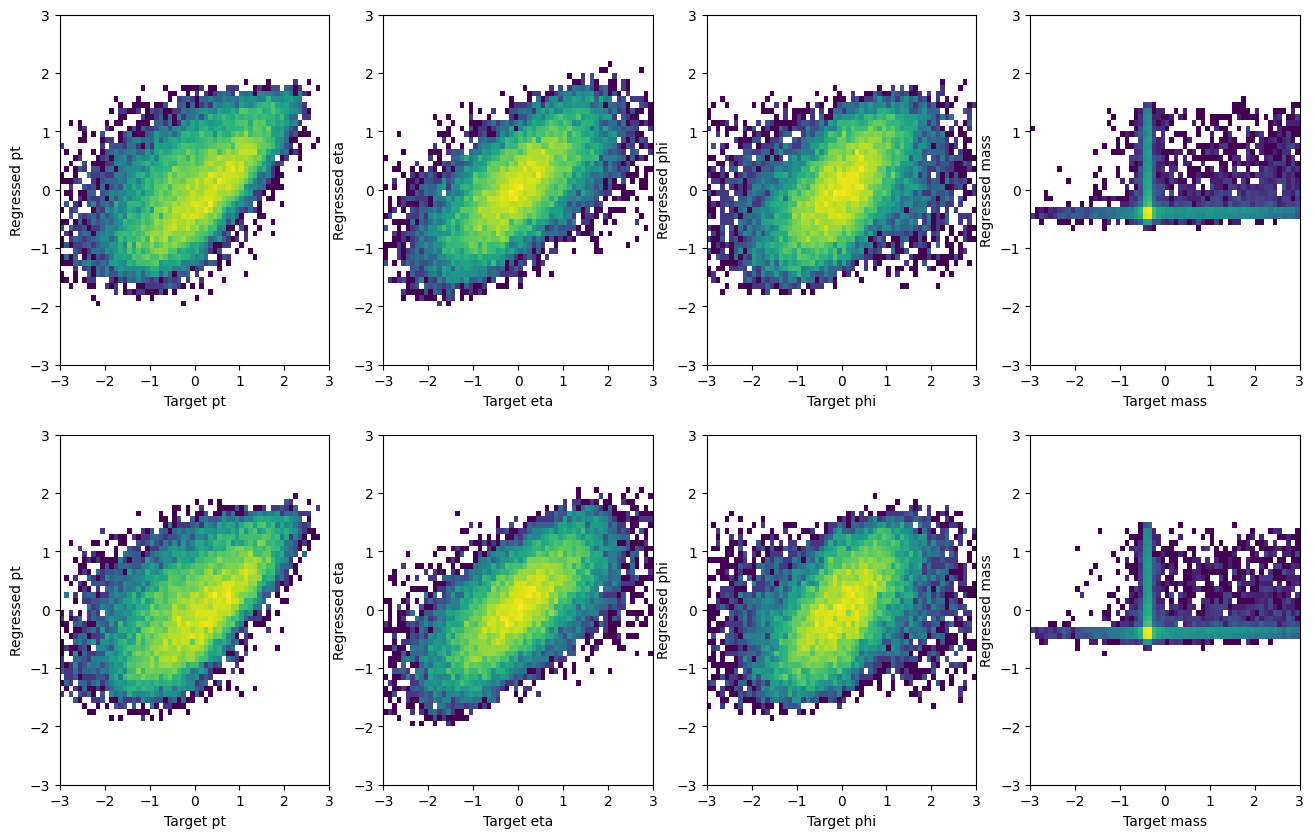

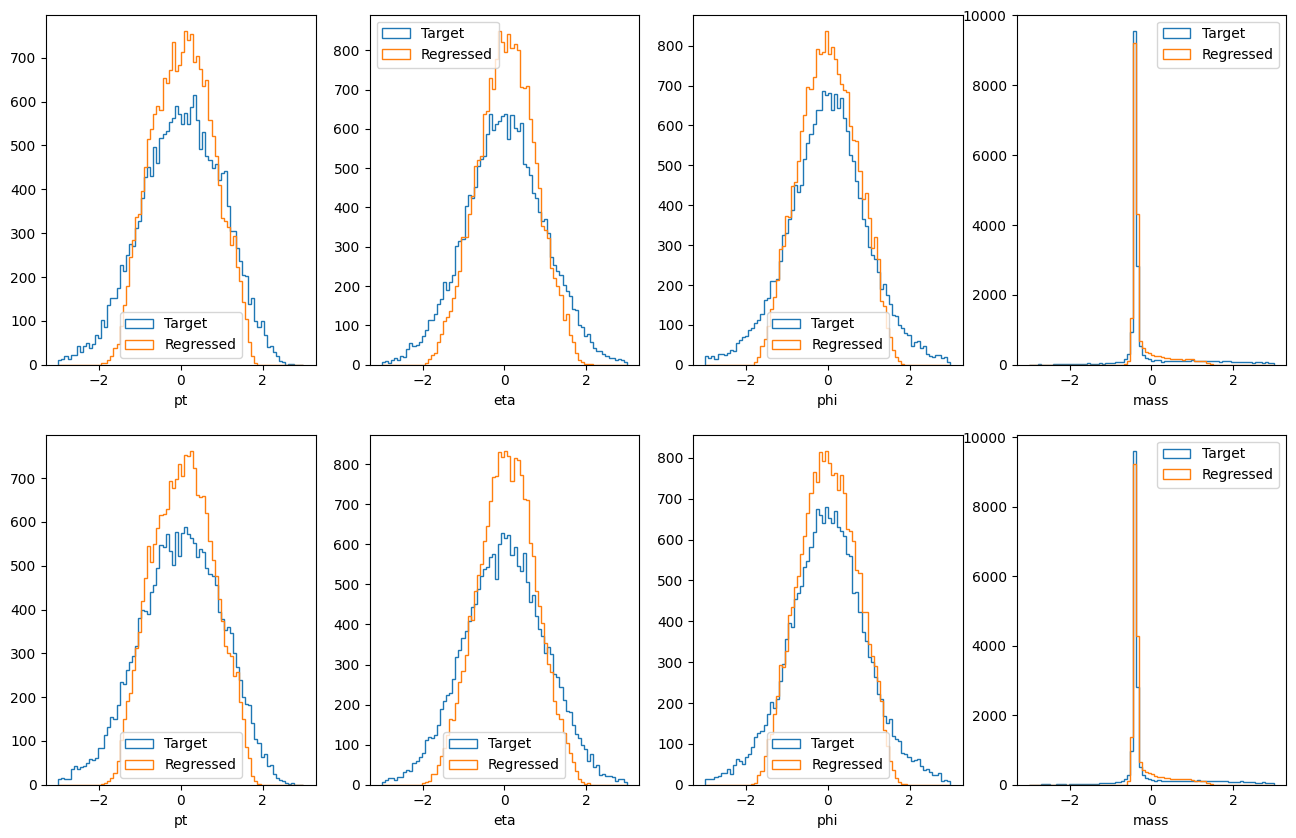

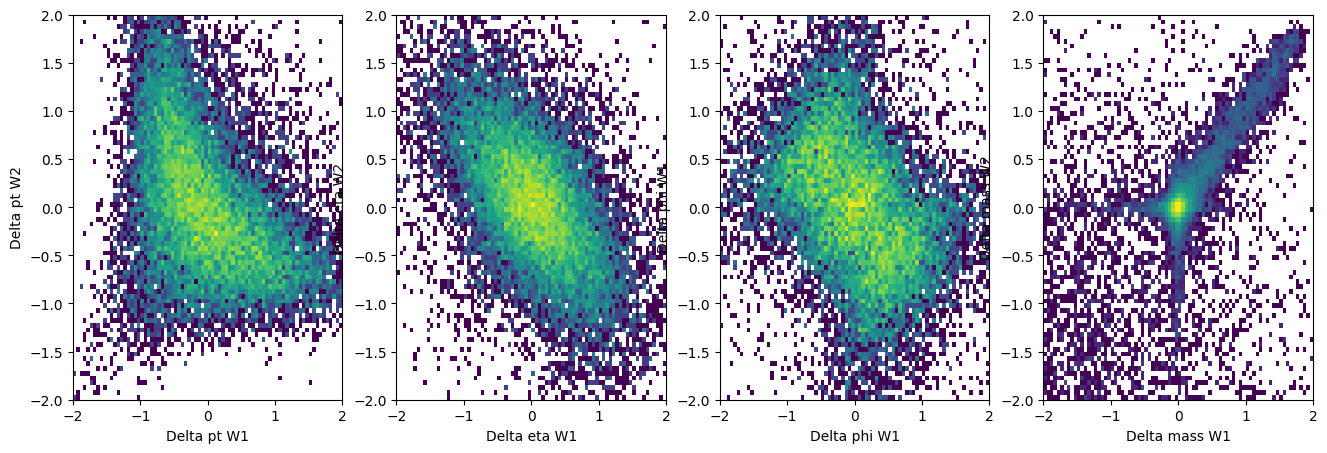

In [22]:
validation_plots(W, W_out)

In [20]:
torch.save(model.state_dict(), "models/model_WWregr_mmdloss.pt")

## Periodic-phi loss

The MSE or Huber loss for the phi variable is not taking into account the intrinsic periodicity of the phi variable. 
To take take into account we have to rescale the phi feature to the original [-pi, pi] space, and take the distance between the target and the regressed phi considering the periodicity. 

In [9]:
def logistic(x):
    return 1/(1+torch.exp(-x))

def logit(x, clip=1e-6):
    x = np.clip(x, a_min=clip, a_max=1-clip)
    return np.log(x/(1-x))

In [10]:
phi_scaling = torch.from_numpy(np.load(f"{datafolder}/W_data_scaling.npy")[2]).to("cuda")

def unscale_phi(phi):
    return  logistic((phi * phi_scaling[1])+phi_scaling[0])* 2 *np.pi - np.pi

def phi_loss(phi_x, phi_y, loss_fn):
    unscaled_x = unscale_phi(phi_x)
    unscaled_y = unscale_phi(phi_y)
    deltaPhi = torch.abs(unscaled_x - unscaled_y)
    deltaPhi = torch.where(deltaPhi > np.pi, deltaPhi - 2*np.pi, deltaPhi)
    deltaPhi = torch.where(deltaPhi <= -np.pi, deltaPhi + 2*np.pi, deltaPhi)
    return deltaPhi

In [ ]:
plt.hist(unscale_phi(W_out[:,:,2].cpu().numpy()).flatten(), 
         bins=100, histtype="step", label="regressed")
plt.hist(unscale_phi(W[:,:,2].cpu().numpy()).flatten(), 
         bins=100, histtype="step", label="target")
plt.legend()
plt.xlabel("W phi");

In [ ]:
phi_loss(W_out[:,:,2], W[:,:,2], torch.nn.MSELoss())

In [ ]:
def train_withMMD_philoss(model, device, loader, val_loader,  optimizer, criterion, epochs, plot=False):
    for epoch in range(epochs):
        model.train()
        for batch_idx, (jets, lepton, met, full_mask, nu, W) in enumerate(loader):
            
            optimizer.zero_grad()
            W_out = model(jets, lepton, met, full_mask==0)
            mask_nan = torch.isnan(W_out).any(axis=(1,2))
            MMDs_1 = []
            MMDs_2 = []
            for i in range(4):
                MMDs_1.append(MMD(W[~mask_nan][:,0,i:i+1], W_out[~mask_nan][:,0,i:i+1], kernel="multiscale", device=device, dtype=torch.float32))
                MMDs_2.append(MMD(W[~mask_nan][:,1,i:i+1], W_out[~mask_nan][:,1,i:i+1], kernel="multiscale", device=device, dtype=torch.float32))
            MMD_loss_1 = sum(MMDs_1)/4
            MMD_loss_2 = sum(MMDs_2)/4
            
            loss_huber = criterion(W_out[:,:,0:2], W[:,:,0:2]).nanmean() +\
                         criterion(W_out[:,:,3], W[:,:,3]).nanmean() + \
                         phi_loss(W_out[:,:,2], W[:,:,2], criterion).nanmean()
            loss =  loss_huber +  MMD_loss_1 + MMD_loss_2
            
            
            if batch_idx % 100 == 0:
                print(f"epoch {epoch}, step {batch_idx}, Loss: {loss.item():.4f}, loss regr: {loss_huber.item():.4f},  MMD W1: {MMD_loss_1.item():.4f}, MMD W2: {MMD_loss_2.item():.4f} ")
                    
            loss.backward()
            optimizer.step()
        # Log metrics
        
        # Validation loss
        #model.eval()  #I'm having problems with model.eval
        val_loss = 0.  
        val_loss_huber = 0.
        val_loss_mmd_w1 = 0.
        val_loss_mmd_w2 = 0.
        
        with torch.no_grad():
            for jets_val, lepton_val, met_val ,full_mask_val, nu_val, W_val in val_loader:
                W_out_val = model(jets_val, lepton_val, met_val, full_mask_val==0)
       
                mask_nan_val = torch.isnan(W_out_val).any(axis=(1,2))
                MMDs_1_val = []
                MMDs_2_val = []
                for i in range(4):
                    MMDs_1_val.append(MMD(W_val[~mask_nan_val][:,0,i:i+1], W_out_val[~mask_nan_val][:,0,i:i+1], kernel="multiscale", device=device, dtype=torch.float32))
                    MMDs_2_val.append(MMD(W_val[~mask_nan_val][:,1,i:i+1], W_out_val[~mask_nan_val][:,1,i:i+1], kernel="multiscale", device=device, dtype=torch.float32))
                MMD_loss_1_val = sum(MMDs_1_val)/4
                MMD_loss_2_val = sum(MMDs_2_val)/4
                
                loss_huber_val = criterion(W_out_val[:,:,0:2], W_val[:,:,0:2]).nanmean() +\
                         criterion(W_out_val[:,:,3], W_val[:,:,3]).nanmean() + \
                         phi_loss(W_out_val[:,:,2], W_val[:,:,2], criterion).nanmean()

                
                val_loss += (loss_huber_val +  MMD_loss_1_val + MMD_loss_2_val).item()
                val_loss_huber += loss_huber_val.item()
                val_loss_mmd_w1 += MMD_loss_1_val.item()
                val_loss_mmd_w2 += MMD_loss_2_val.item()
                
            val_loss = val_loss / len(val_loader)
            val_loss_huber = val_loss_huber / len(val_loader)
            val_loss_mmd_w1 = val_loss_mmd_w1 / len(val_loader)
            val_loss_mmd_w2 = val_loss_mmd_w2 / len(val_loader)
            
            print(f"epoch {epoch}, Validation Loss: {val_loss:.4f}, loss regr: {val_loss_huber:.4f},  MMD W1: {val_loss_mmd_w1:.4f}, MMD W2: {val_loss_mmd_w2:.4f} ")

            #print for one batch
            if plot:
                _ = validation_plots(W_val, W_out_val)
                plt.show()
            
        print(f"End of epoch {epoch}")
    return model

In [ ]:
num_epochs = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

d_model = 32
nhead = 4
num_encoder_layers = 4
num_decoder_layers = 2
learning_rate = 1e-4

model = WWRegressorComplete(d_model, nhead, num_encoder_layers, num_decoder_layers,
                   regression_net=[32])
model.to(device)

print(f"Model with {count_parameters(model)} parameters")

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
#criterion = torch.nn.HuberLoss(delta=2., reduction='none')
criterion = torch.nn.MSELoss(reduction='none')

trained_model = train_withMMD_philoss(model, device, dataloader_train, dataloader_val, optimizer, criterion, num_epochs)

In [ ]:
with torch.no_grad():
    model.train()
    jets, lepton, met,full_mask, nu, W = dataset_val[0:50000]
    W_out = model(jets, lepton, met,full_mask)
    loss = criterion(W_out, W)

In [ ]:
validation_plots(W, W_out)

In [ ]:
plt.hist(unscale_phi(W_out[:,:,2]).cpu().numpy().flatten(), 
         bins=100, histtype="step", label="regressed")
plt.hist(unscale_phi(W[:,:,2]).cpu().numpy().flatten(), 
         bins=100, histtype="step", label="target")
plt.legend()
plt.xlabel("W phi");

In [ ]:
torch.save(model.state_dict(), "models/model_wwregress_mmd_phiperiodic.pt")

# Constrained optimization

We would like to have an even lower value of the MMD loss to fully match the distributions of the target W bosons. 
The problem is that the scale of the MMD loss is now much lower than the value of the regression loss. 
The optimizer won't focus on the MMD loss at this level in the numerial optimization of the loss. 

In order to constraint the distribution even more we should give more weight to the MMD loss. A common solution is to just increase the *relative weight* of the MMD loss in the total loss: 
$$ loss = loss_{regr} + \lambda \cdot loss_{MMD}$$.

This solution is usually fine, but optimizing for the best value of $\lambda$ can be problematic (see slides). 

A more stable and consistent solution is using the *Modified Differential Multiplier Method* (mdmm) [article](https://www.engraved.blog/how-we-can-make-machine-learning-algorithms-tunable/). See slides for full explanation.


In [4]:
def compute_MMD_loss(W_x, W_y):
    mmds = []
    for p in range(2):
        for i in range(4):
            mmds.append(MMD(W_y[:,p,i:i+1], W_x[:,p,i:i+1], kernel="multiscale", device=W_x.device, dtype=W_x.dtype))
    return sum(mmds)/8

def compute_regr_loss(W_x, W_y, loss_fn):
    return loss_fn(W_x[:,:,0:2], W_y[:,:,0:2]).nanmean() +\
                 loss_fn(W_x[:,:,3], W_y[:,:,3]).nanmean() + \
                 phi_loss(W_x[:,:,2], W_y[:,:,2], loss_fn).nanmean()
    

In [13]:
def train_withMMD_philoss_mdmmconstraint(model, MDMM_module, device, loader, val_loader,  optimizer, criterion, epochs, plot=False):
    for epoch in range(epochs):
        model.train()
        for batch_idx, (jets, lepton, met, full_mask, nu, W) in enumerate(loader):
            
            optimizer.zero_grad()
            W_out = model(jets, lepton, met, full_mask==0)
            mask_nan = torch.isnan(W_out).any(axis=(1,2))
            mask_notnan = ~mask_nan

            loss_regr = compute_regr_loss(W_out, W, criterion)
            # Now using MDMM for the MMD loss
            mdmm_return = MDMM_module(loss_regr, [(W_out[mask_notnan], W[mask_notnan])])
            # Using the output of the MDMM module as the total loss to optimize --> this includes the modified constraint terms
            loss = mdmm_return.value
            # Getting the MDMM value anyway to log it 
            MMD_loss = compute_MMD_loss(W_out[mask_notnan], W[mask_notnan])
            
            if batch_idx % 100 == 0:
                print(f"epoch {epoch}, step {batch_idx}, Loss: {loss.item():.4f}, loss regr: {loss_regr.item():.4f},  MMD total: {MMD_loss.item():.4f} ")
                 
            loss.backward()
            optimizer.step()
            
        # Validation loss
        #model.eval()  #I'm having problems with model.eval
        val_loss = 0.  
        val_loss_regr = 0.
        val_loss_mmd = 0.
        
        with torch.no_grad():
            for jets_val, lepton_val, met_val ,full_mask_val, nu_val, W_val in val_loader:
                W_out_val = model(jets_val, lepton_val, met_val, full_mask_val==0)
       
                mask_nan_val = torch.isnan(W_out_val).any(axis=(1,2))
                mask_notnan_val = ~mask_nan_val
                MMD_loss_val = compute_MMD_loss(W_out_val[mask_notnan_val], W_val[mask_notnan_val])
                
                loss_regr_val = compute_regr_loss(W_out_val, W_val, criterion)
                    
                val_loss += (loss_regr_val +  MMD_loss_val).item()
                val_loss_regr += loss_regr_val.item()
                val_loss_mmd += MMD_loss_val.item()
                
            val_loss = val_loss / len(val_loader)
            val_loss_regr = val_loss_regr / len(val_loader)
            val_loss_mmd = val_loss_mmd / len(val_loader)
            
            print(f"epoch {epoch}, Validation Loss: {val_loss:.4f}, loss regr: {val_loss_regr:.4f},  MMD total: {val_loss_mmd:.4f}")

            #print for one batch
            if plot:
                _ = validation_plots(W_val, W_out_val)
                plt.show()
            
        print(f"End of epoch {epoch}")
    return model

In [14]:
datafolder = "/eos/user/d/dvalsecc/EFT_PhD_Course/training_datasets"

# Usage example
input_paths_training = [ f"{datafolder}/{f}_training.npy" for f in ["jet_data", "lepton_data", "met_data","jetlepmet_padding_mask",  "nu_data", "W_data"]]
input_paths_validation = [ f"{datafolder}/{f}_validation.npy" for f in ["jet_data", "lepton_data", "met_data","jetlepmet_padding_mask", "nu_data", "W_data"]]

dataset_train = dataloader.ChunkedNumpyDataset(input_paths_training, max_events=600000, device="cuda")
dataset_val  = dataloader.ChunkedNumpyDataset(input_paths_validation, max_events=200000, device="cuda")

# Create DataLoader
batch_size = 1024
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size*6, shuffle=False)

The preparation of the optimize is different to use the mdmm code.

Many types of constraints can be specified.  In this case we use a MAX constraint. 
The loss will be increased if the small MMD value is not reached during the training. 

In [ ]:
max_MMD_constraint = 1e-3
scale_MMD_constraint = 20.

num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
d_model = 32
nhead = 4
num_encoder_layers = 4
num_decoder_layers = 2
learning_rate = 1e-3

model = WWRegressorComplete(d_model, nhead, num_encoder_layers, num_decoder_layers,
                   regression_net=[32])
model.to(device)

constraint = mdmm.MaxConstraint(
                    compute_MMD_loss,
                    max_MMD_constraint,
                    scale=scale_MMD_constraint,
                    damping=1.,
                    )

# Create the optimizer
MDMM_module = mdmm.MDMM([constraint]) # support many constraints TODO: use a constraint for every particle

optimizer = MDMM_module.make_optimizer(model.parameters(), lr=learning_rate, optimizer=torch.optim.AdamW)
criterion = torch.nn.MSELoss(reduction='none')

trained_model = train_withMMD_philoss_mdmmconstraint(model, MDMM_module, device, dataloader_train, dataloader_val, optimizer, criterion, num_epochs)

In [18]:
with torch.no_grad():
    model.train()
    jets, lepton, met,full_mask, nu, W = dataset_val[0:20000]
    W_out = model(jets, lepton, met,full_mask)
    loss = criterion(W_out, W)

(<Figure size 1600x1000 with 8 Axes>,
 <Figure size 1600x1000 with 8 Axes>,
 <Figure size 1600x500 with 4 Axes>)

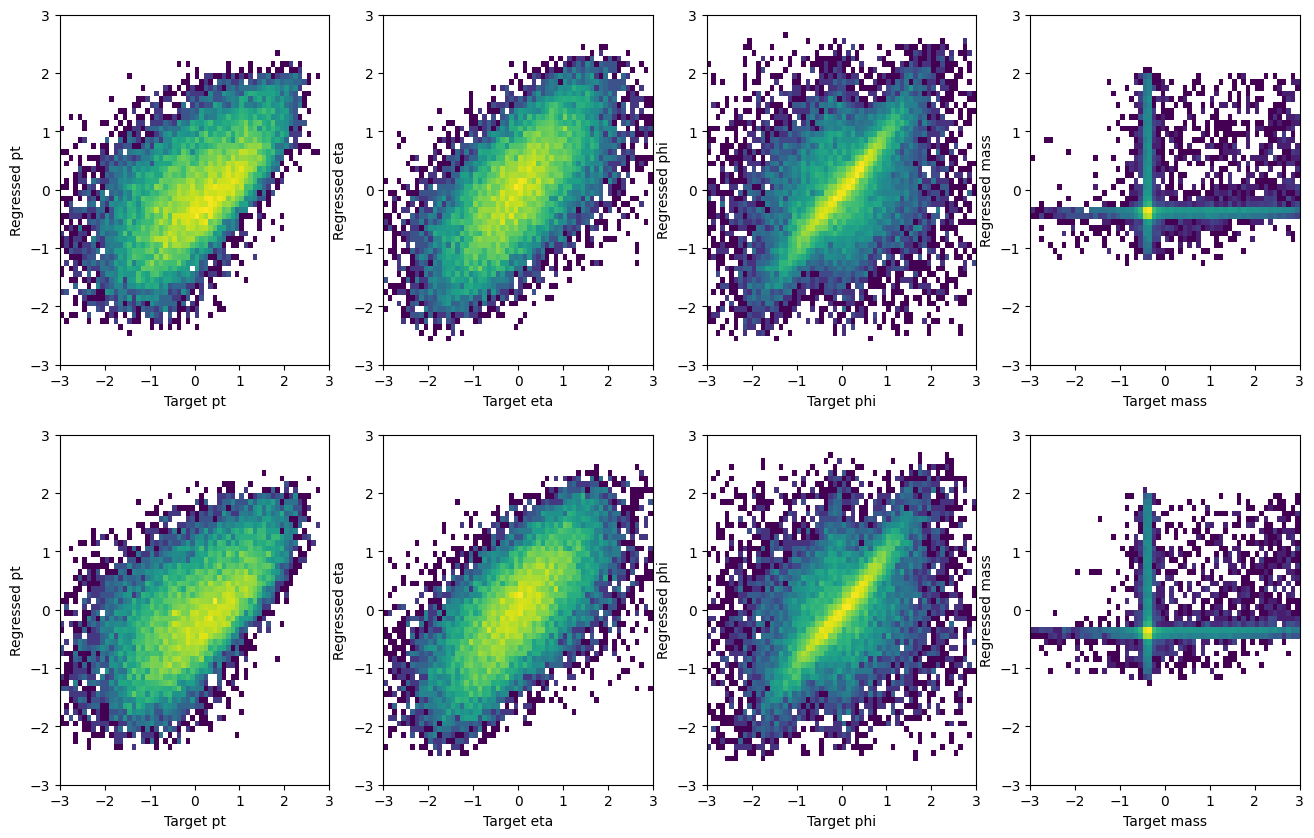

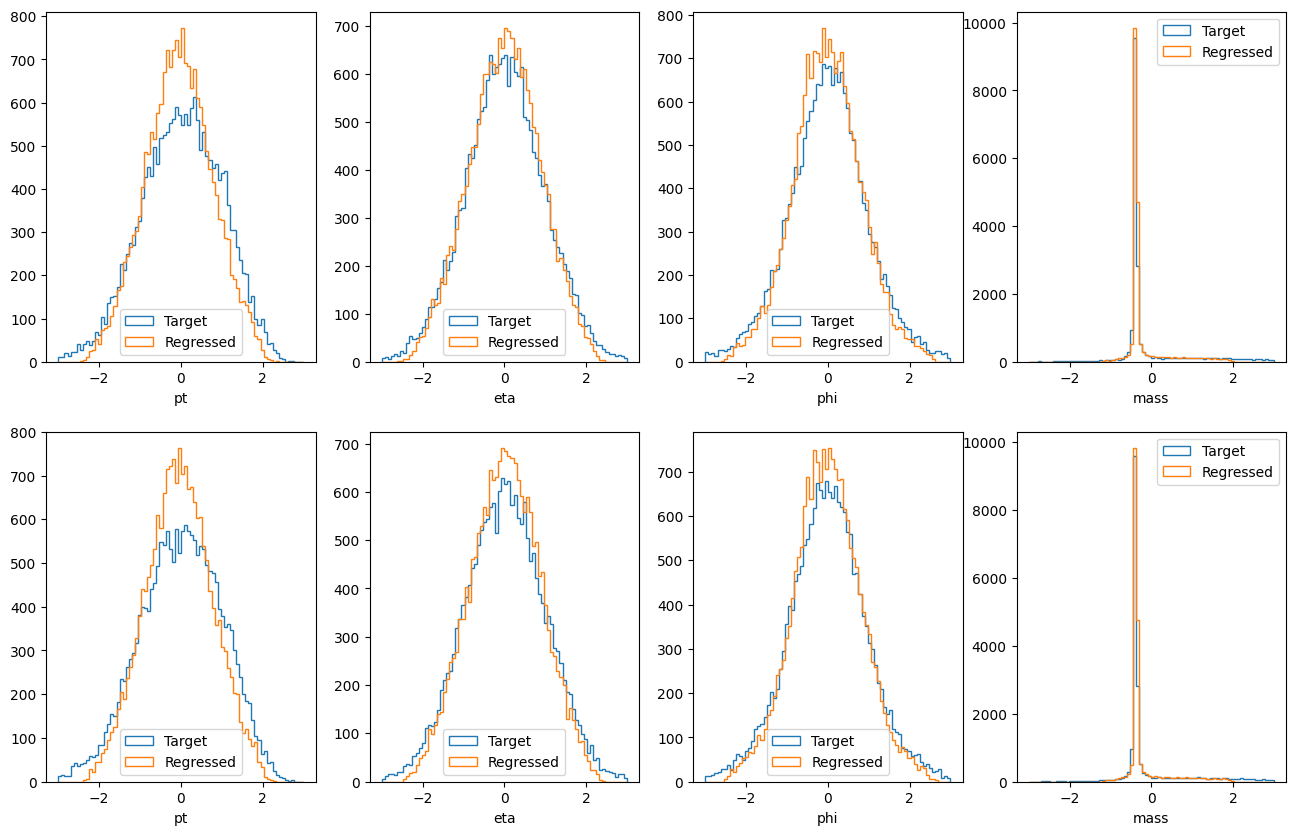

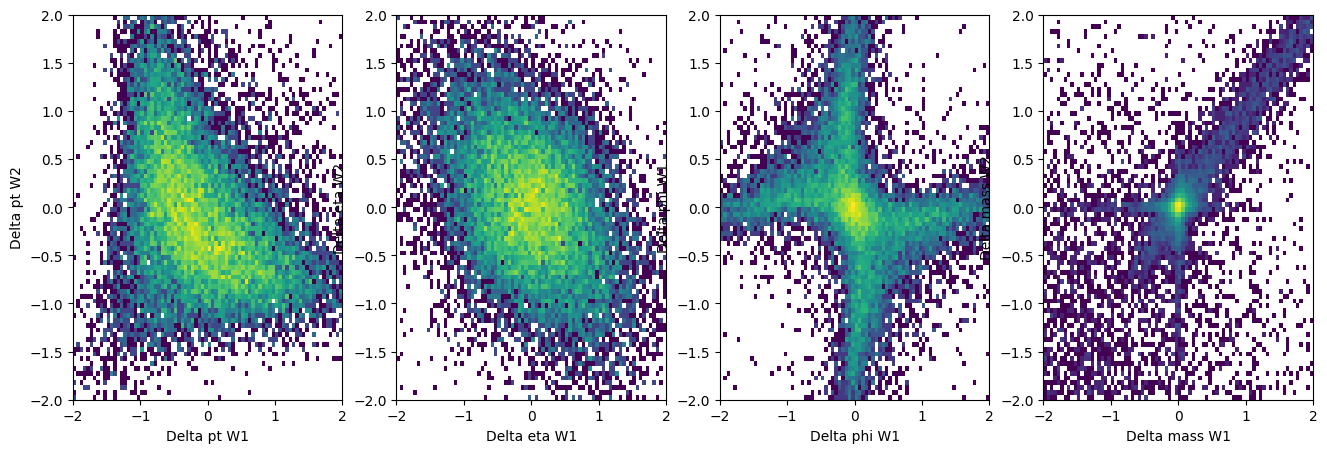

In [21]:
validation_plots(W, W_out)

In [ ]:
torch.save(model.state_dict(), "models/model_WWregr_mmd_phiperiodic_MDMMconstraints.pt")

# Comparison with a very simple DNN